## Whole Slide Imaging De-identification

In this notebook, we will explore how to handle the de-identification of Whole Slide Imaging (WSI) files, specifically focusing on SVS files.</br>
We will cover:
* Removal of auxiliary images, like macro and label images.
* Removal of Metadata.
* Main image cleaning: in this situation we don't want to remove the entire image like the case of for example macro or label images, but we want to remove only specific regions which contain PHI. We want to do this keeping the quality of the original image intact. This process involves the following steps which we will discuss in next sections,
  * Extract Tiles from SVS
  * Deidentify Tiles
  * Update the original source SVS file to mask tiles containing PHI.

Let's jump right in!

### Introduction to the SVS file format

The SVS file format (commonly used for whole slide images (WSI) in digital pathology) is based on the TIFF format and supports multi-resolution (pyramidal) image storage. It allows storing extremely large images efficiently, along with metadata and multiple resolutions for fast zooming and viewing.
SVS typically stores images in a pyramid of resolutions,
* level 0 -> full resolution.
* level 1 -> downsampled version, like 1/4 of the resolution at level 0.
* ...
* level N -> more downsampling.

Something like this(image taken from nema.org),</br>
![sample wsi](https://dicom.nema.org/dicom/dicomwsi/sup145_fromword_files/image008.gif)

At each level, images are not stored as a single monolithic unit, but as a set of _tiles_. This enables for a more efficient handling of the image by viewers.</br>
We'll see how we can exploit this characteristic to process the images in parallel and in the most efficient manner.

### Real World Example

In [ ]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

### Initialization of spark session

In [ ]:
import os
from sparkocr import start

spark = start(jar_path=spark_ocr_jar_path,
              nlp_internal=True,
              nlp_jsl=True,
              nlp_version="6.1.1",
              use_gpu=True)

spark

### Removal of auxiliary images, like macro and label images, along with metadata.
First things first, before diving into the full resolution images, let's see how to remove the auxiliary images and the metadata. For this, the `svs.remove_phi()` comes handy. Let's take a look at the documentation,

In [60]:
from sparkocr.utils.svs.deidentifier import remove_phi
help(remove_phi)

Help on function remove_phi in module sparkocr.utils.svs.deidentifier:

remove_phi(input, output, tags=['ImageDescription.Filename', 'ImageDescription.Date', 'ImageDescription.Time', 'ImageDescription.User'], append_tags=[], rename=False, verbose=False)
    Remove label images, macro images, and specified metadata from SVS files.
    
    This function processes SVS files to remove sensitive metadata and associated images. 
    By default, it removes specific metadata tags: "ImageDescription.Filename", 
    "ImageDescription.Date", "ImageDescription.Time", and "ImageDescription.User".
    
    Parameters:
    - input (str): The file path or directory containing the SVS files to be de-identified.
    - output (str): The file path or directory where the de-identified files will be saved.
    - tags (list, optional): A list of metadata tags to remove, replacing the default tags if provided.
    - append_tags (list, optional): Additional tags to remove, added to the defaults without overri

So we see from the documentation that we can remove label, and macro images along with a predefined set of metadata tags. We can also add our own custom list of tags.</br>
We have everything we need, so let's do it!,

In [61]:
# make sure input files are in this folder
input_path = './data/svs/62893.svs'
output_path = "deid_svs"

remove_phi(input_path, output_path, verbose=True)

#### [optional] Tweaking additional parameters
You can safely skip this if you are good with the set of metadata tags that were removed.

In [62]:
input_path = './data/svs/62893.svs'
output_path = "svs_output"

remove_phi(input_path, output_path, verbose=True, append_tags=['ImageDescription.ScanScope ID', 'ImageDescription.Time Zone', 'ImageDescription.ScannerType'])

#### Cleaning of the main image
Here we will de-identify the main image. We start by pulling the tiles out of the SVS.

In [5]:
!mkdir tiles_output

In [4]:
from sparkocr.utils.svs.extract_tiles import process_folder

OUTPUT_FOLDER = "tiles_output/"

NUM_WORKERS = 4
process_folder(input_path, OUTPUT_FOLDER, NUM_WORKERS)

Processing 62893.svs...
Extracting 35 tiles from Level 0...


Level 0: 100%|██████████| 35/35 [00:02<00:00, 16.95it/s]


Extracting 6 tiles from Level 1...


Level 1: 100%|██████████| 6/6 [00:00<00:00, 13.40it/s]


#### Text Detection

In [3]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images, to_pil_image

In [4]:
# Repeating the definition here for this path
temp_tile_output = "./tiles_output/"
image_df = spark.read.format("binaryFile").load(temp_tile_output)

At this point, `image_df` has all the tiles, from every level in the source SVS file. Next thing we need to do is to try to detect text and PHI in those tiles.</br>
Let's define the pipeline steps we need to accomplish this.

In [5]:
bin_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setImageType(ImageType.TYPE_BYTE_GRAY) \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setUseGPU(True) \
    .setWidth(0)

new_stages = [
    bin_to_image,
    text_detector
]

svs_text_detection = PipelineModel(stages=new_stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


In [6]:
result = svs_text_detection.transform(image_df)

In [7]:
df_tile = result.select("text_regions", "exception")

In [8]:
result.select("text_regions", "exception").show(5, False)

+-------------------------------------------------------------------------------------------------------------------------+---------+
|text_regions                                                                                                             |exception|
+-------------------------------------------------------------------------------------------------------------------------+---------+
|[]                                                                                                                       |NULL     |
|[{0, 0, 974.0, 282.0, 111.999985, 95.999985, 0.8235294, 0, 90.0, true}]                                                  |NULL     |
|[]                                                                                                                       |NULL     |
|[{0, 0, 299.0, 204.0, 40.0, 50.0, 0.7490196, 0, 90.0, true}, {0, 0, 255.0, 207.0, 38.0, 50.0, 0.72156864, 0, 90.0, true}]|NULL     |
|[{0, 0, 165.0, 407.0, 78.0, 90.0, 0.7372549, 0, 90.0, true}] 

**NOTE**: Here we can see the different tiles and the text that was detected on each of them. You can filter the tiles with detected text and use it as input for deid pipeline, other tiles won't be fed into the pipeline, so that we don't waste resources analyzing them.

#### Inspect target images
Let's look into some of the images containing text,


    Image #0:
    Origin: file:/content/tiles_output/62893_L0_T4.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


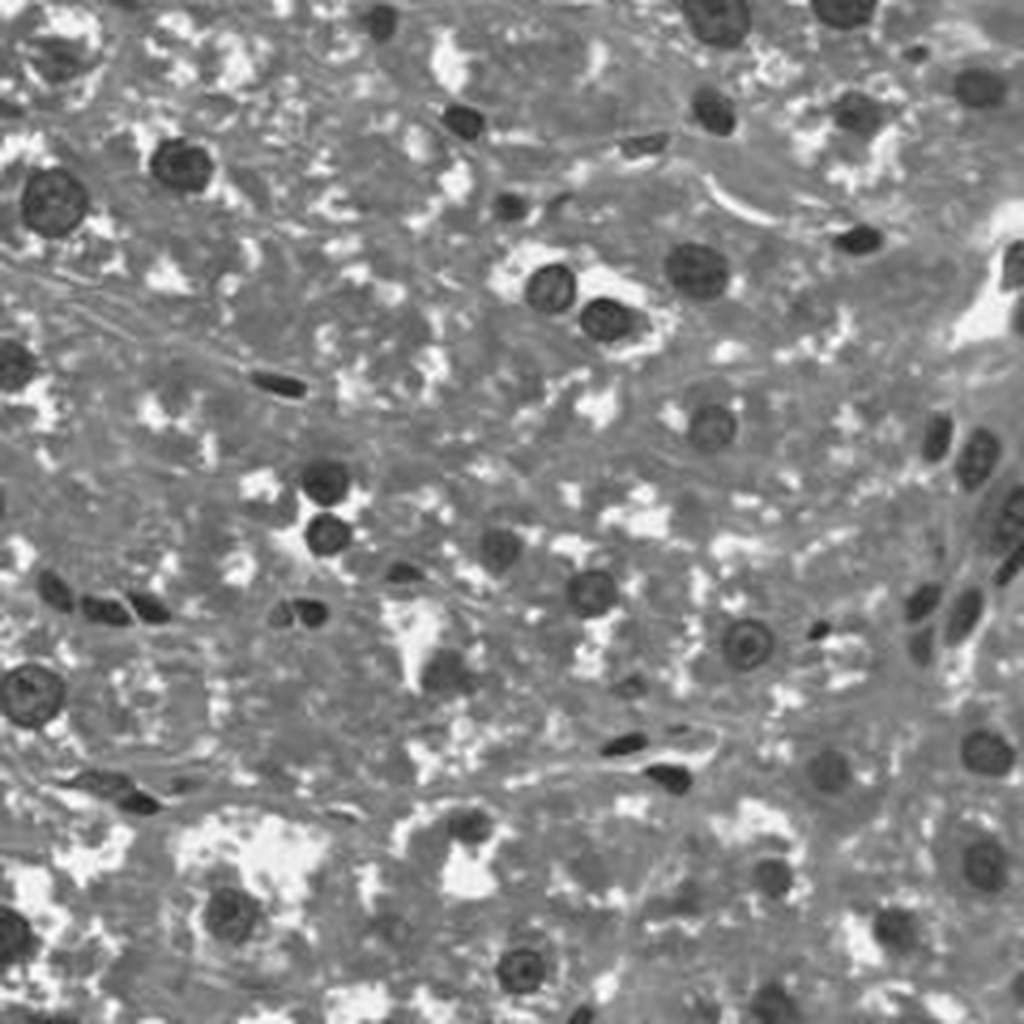


    Image #1:
    Origin: file:/content/tiles_output/62893_L0_T5.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


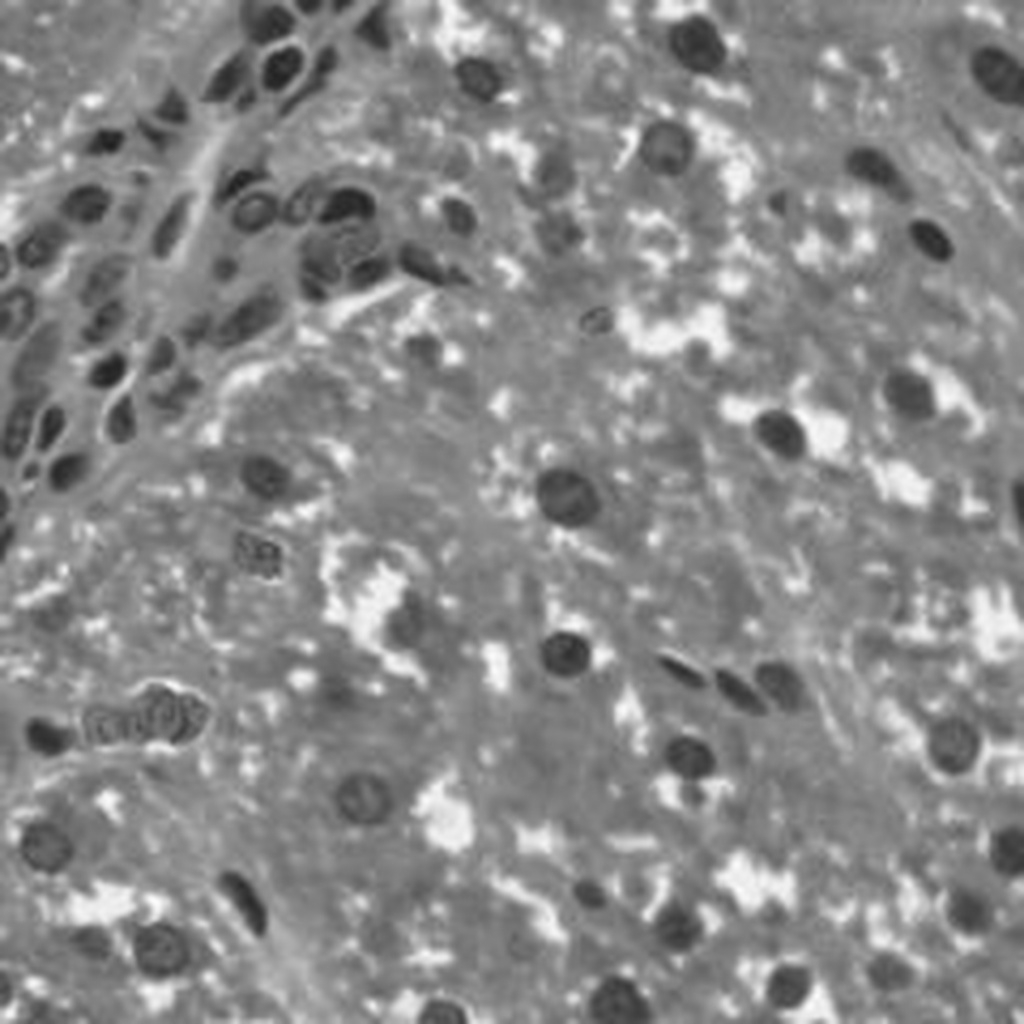


    Image #2:
    Origin: file:/content/tiles_output/62893_L0_T6.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


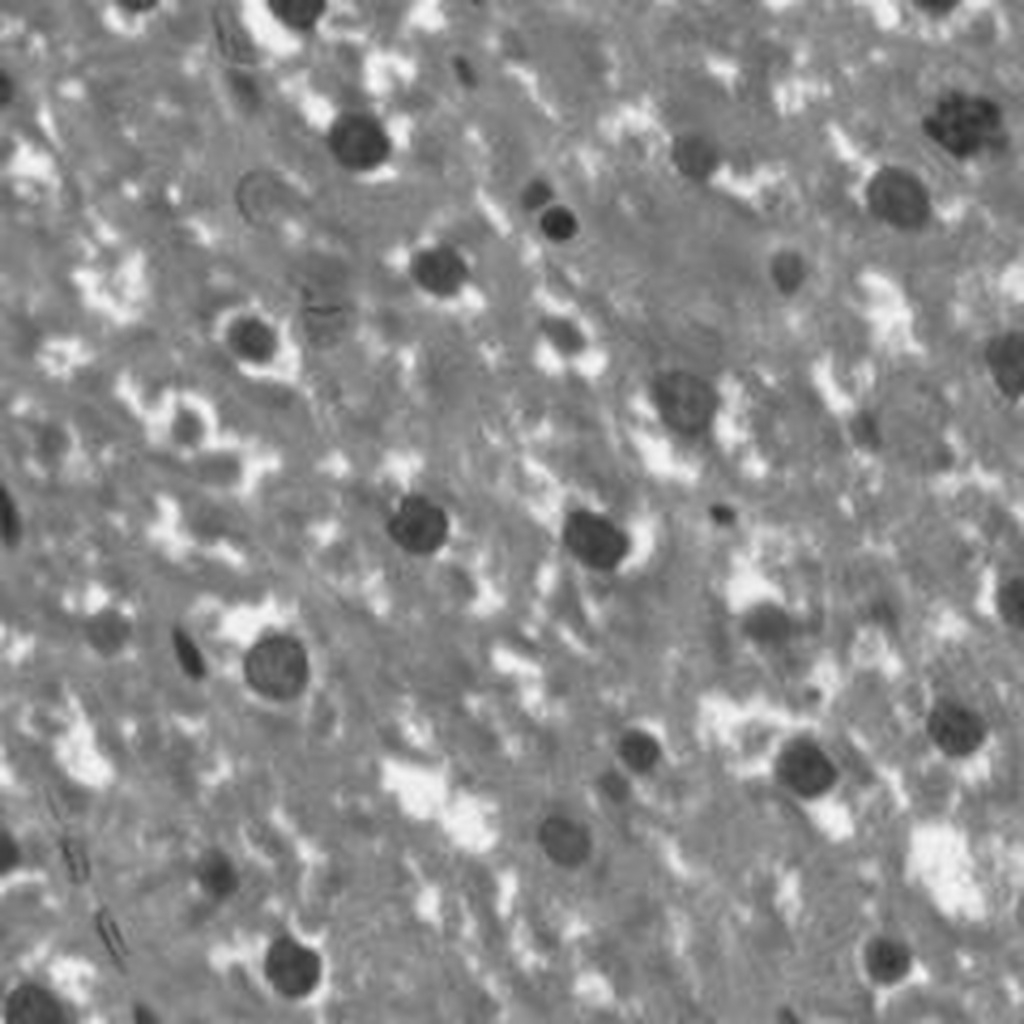


    Image #3:
    Origin: file:/content/tiles_output/62893_L0_T30.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


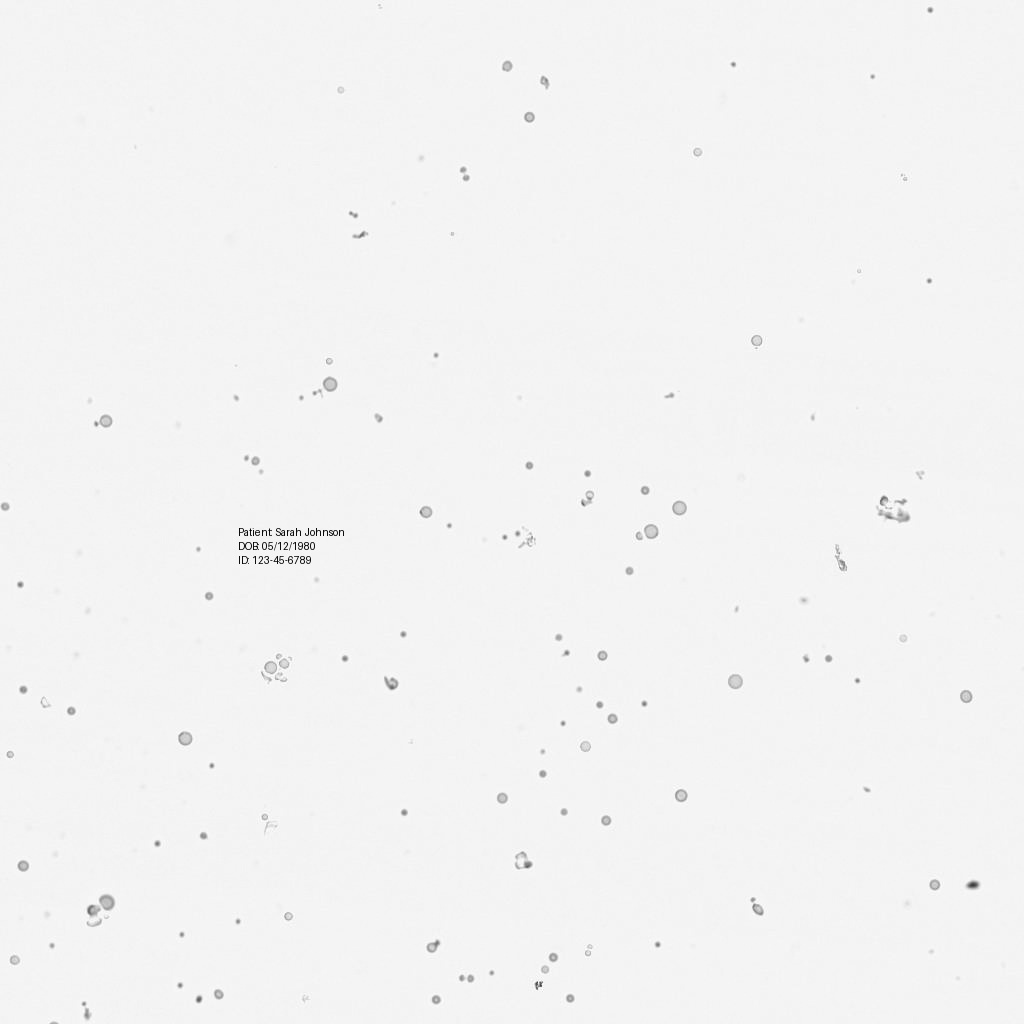


    Image #4:
    Origin: file:/content/tiles_output/62893_L0_T31.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


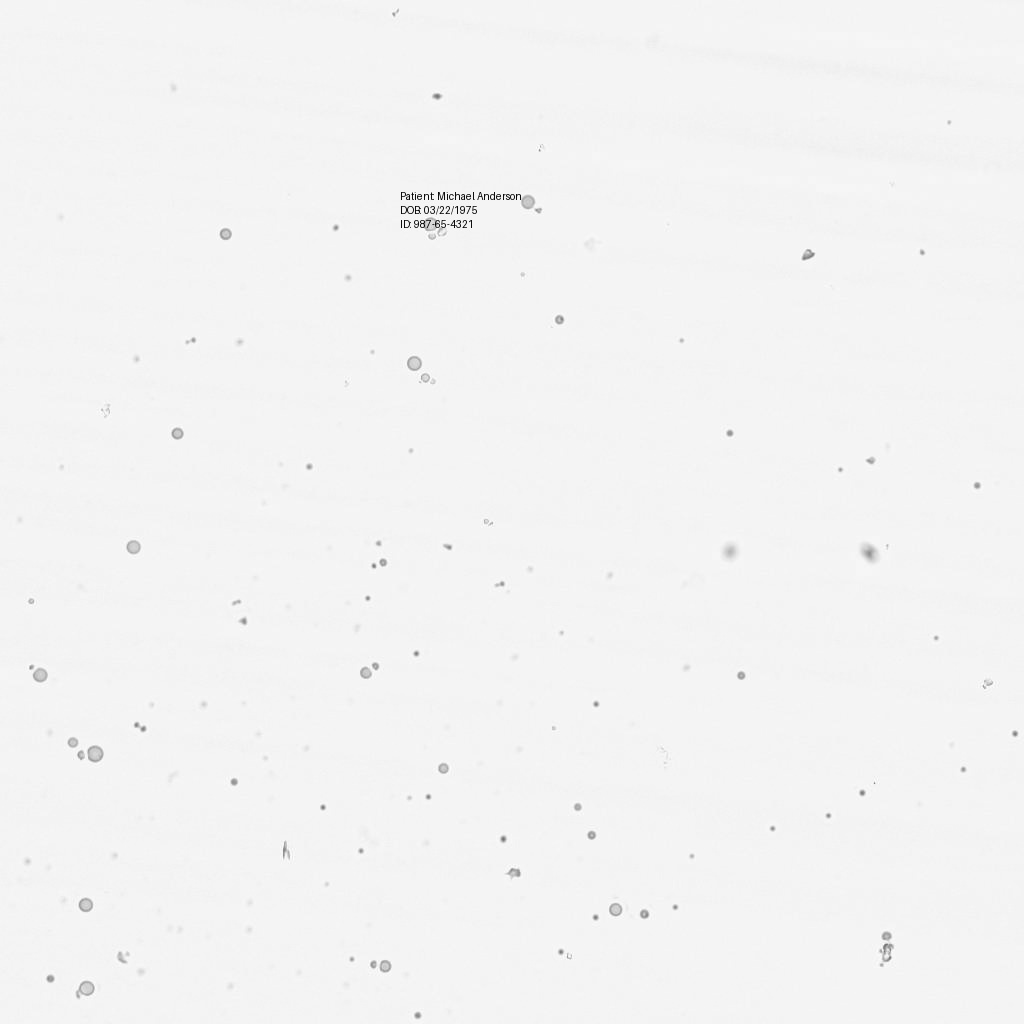

In [9]:
from pyspark.sql.functions import size

result = result.filter(size(result["text_regions"]) > 0).cache()
display_images(result, "image_raw")

#### PHI removal per-se

In [10]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(True) \
    .setUseCaching(True) \
    .setBatchSize(4)

# NLP part begins here :)
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document_raw") \
    .setCleanupMode("shrink")

cleanUpPatterns = ["<[^>]*>", r"\^ ?", r"\^"]
documentNormalizer = DocumentNormalizer() \
  .setInputCols("document_raw") \
  .setOutputCol("document") \
  .setAction("clean") \
  .setPatterns(cleanUpPatterns) \
  .setReplacement(" ") \
  .setPolicy("pretty_all")

sentencerDL = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_subentity")

regex_matcher = RegexMatcher()\
    .setInputCols("sentence")\
    .setOutputCol("regex")\
    .setRules(["[0-9]{4} (JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC) [0-9]{1,2};DATE",
               "(0[1-9]|1[0-2])/(0[1-9]|[12][0-9]|3[01])/\d{4};DATENUM",
               "(?:\s[MF]|\b[MF])(?:\s|\b|$);GENDER",
               "(?<!\d)\d{9,10}(?!\d);ID"])\
    .setDelimiter(";")

chunkConverter = ChunkConverter()\
    .setInputCols("regex")\
    .setOutputCol("regex_chunks")

custom_ner_converter_internal = NerConverterInternalModel() \
    .setInputCols(["sentence","token", "ner_subentity"]) \
    .setOutputCol("ner_chunk") \
    .setThreshold(0.5) \
    .setWhiteList(['NAME', 'AGE', 'LOCATION', 'PERSON', 'DOCTOR', 'PATIENT', 'ID'])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('regex_chunks', "ner_chunk")\
    .setOutputCol('merged_ner_chunk')\
    .setMergeOverlapping(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setOcrScaleFactor(0.9)

drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.gray)

base_stages = [
    ocr,
    documentAssembler,
    documentNormalizer,
    sentencerDL,
    tokenizer,
    word_embeddings,
    clinical_ner,
    regex_matcher,
    chunkConverter,
    custom_ner_converter_internal,
    chunk_merger,
    position_finder,
    drawRegions
]

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


### Run pipeline

In [11]:
deid_tiles = Pipeline(stages=base_stages)
result_deid = deid_tiles.fit(result).transform(result)
deid_info = result_deid.select("path", "coordinates").distinct()

In [48]:
deid_info.distinct().show(5, False)

+-------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|path                                       |coordinates                                                                                                                                                                                      |
+-------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|file:/content/tiles_output/62893_L0_T4.png |[]                                                                                                                                                                                               |
|file:/content/tiles_output/62893_L0_T5.

#### [optional] Cache regions using parquet
We can cache the regions in disk, to avoid potential re-computation and to be able to recover in case of failure.

In [12]:
deid_info.repartition(10).write.format("parquet").mode("overwrite").save("./cached_regions.parquet")

In [13]:
deid_info = spark.read.parquet("./cached_regions.parquet").repartition(10)

#### Display deid tile
Let's take a look at the result of this process


    Image #0:
    Origin: file:/content/tiles_output/62893_L0_T4.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


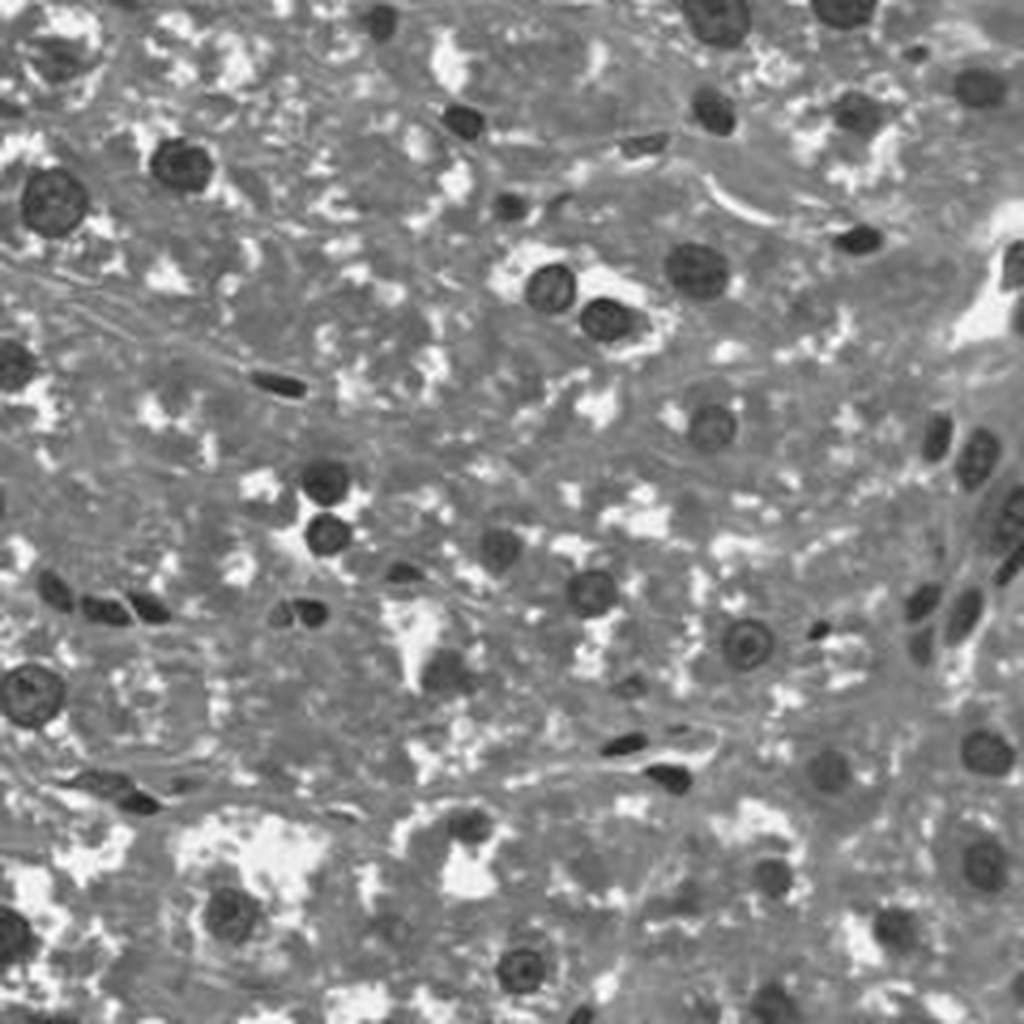


    Image #1:
    Origin: file:/content/tiles_output/62893_L0_T5.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


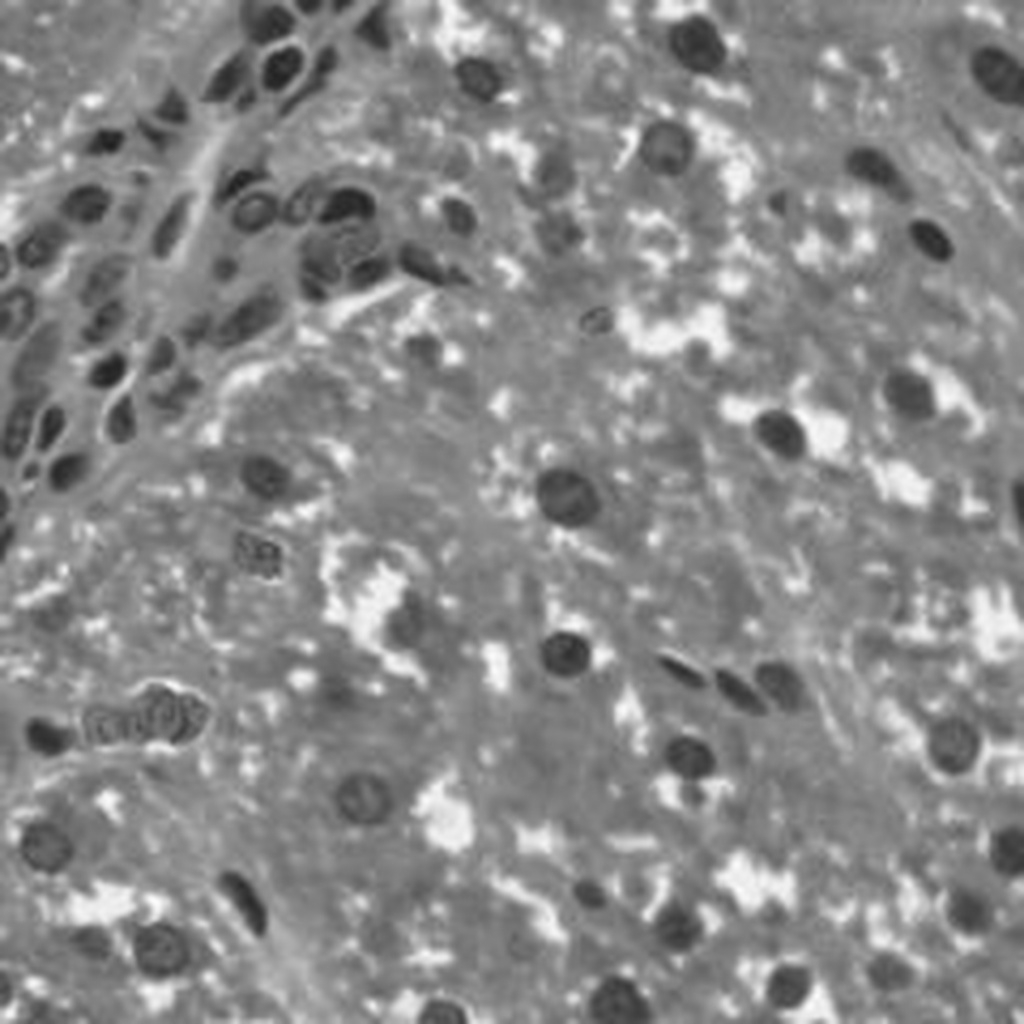


    Image #2:
    Origin: file:/content/tiles_output/62893_L0_T6.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


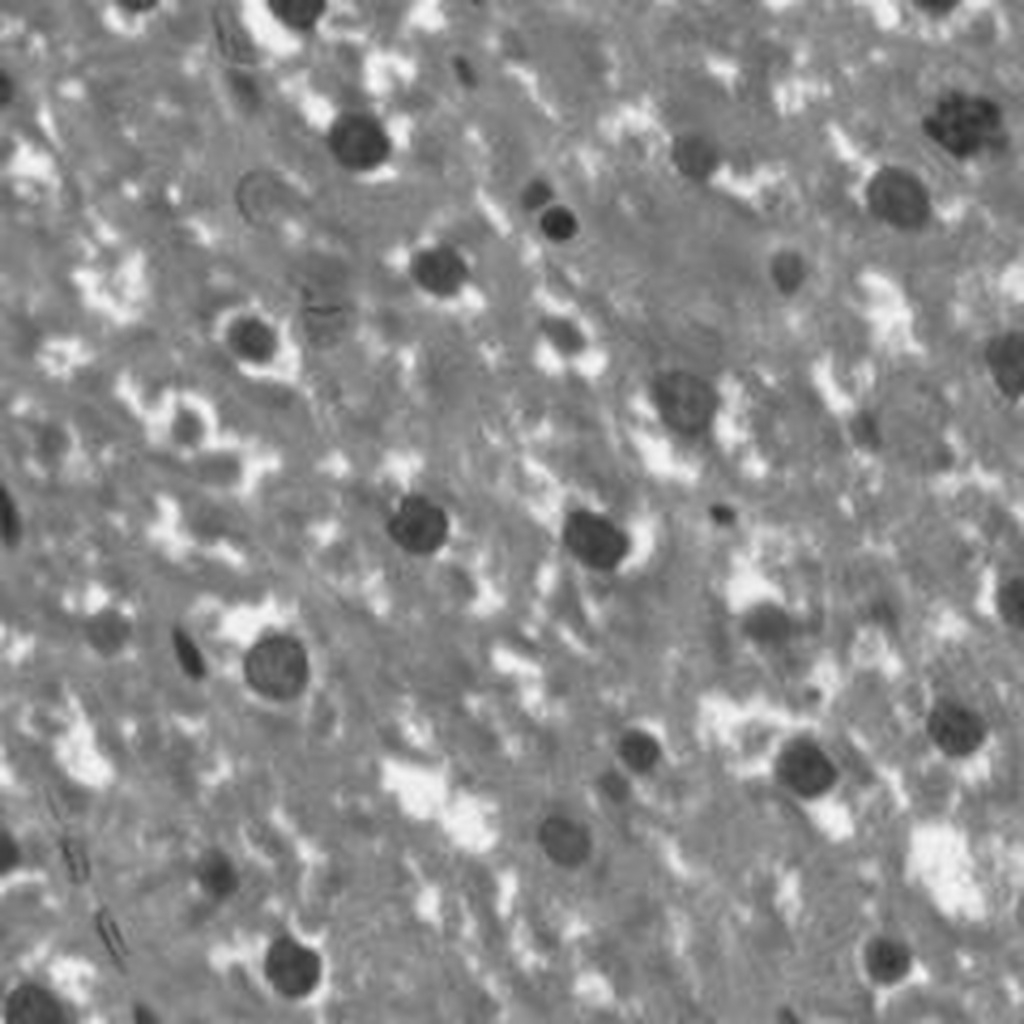


    Image #3:
    Origin: file:/content/tiles_output/62893_L0_T30.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


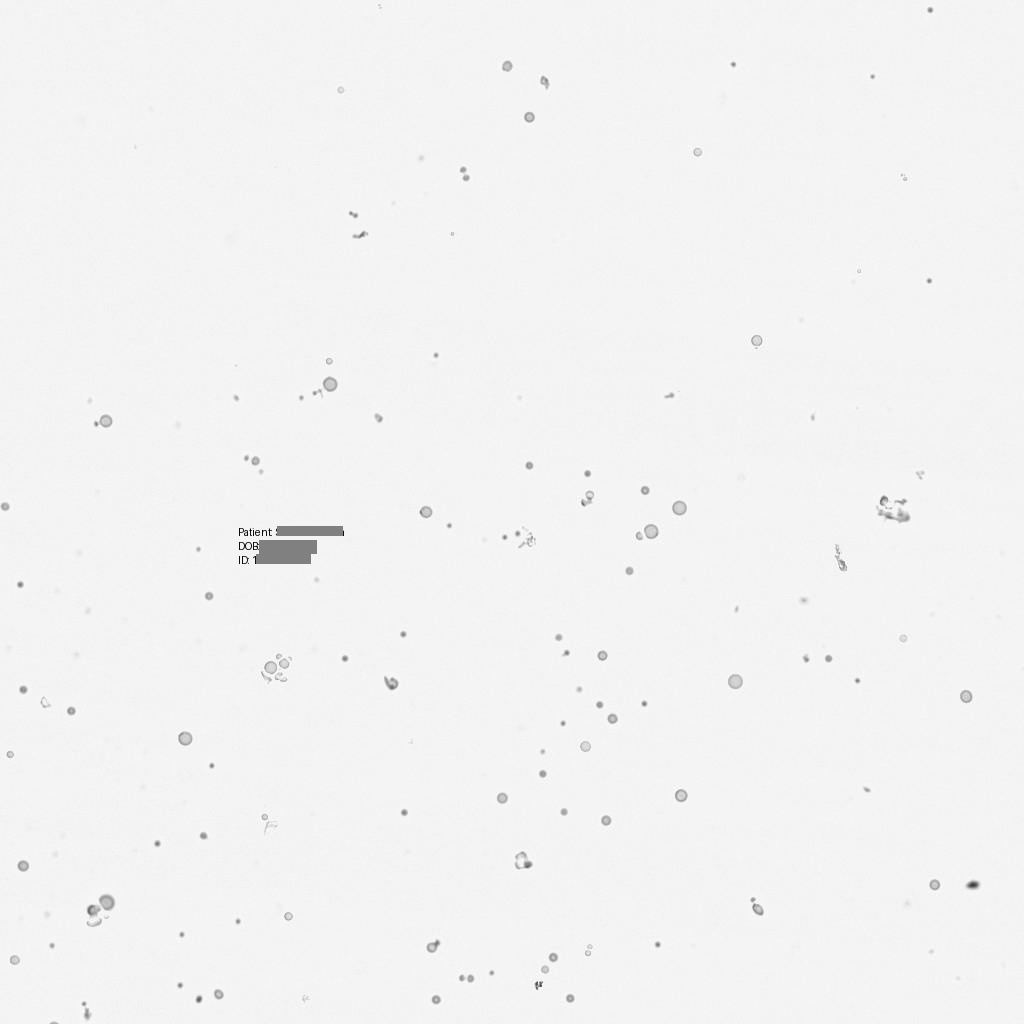


    Image #4:
    Origin: file:/content/tiles_output/62893_L0_T31.png
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


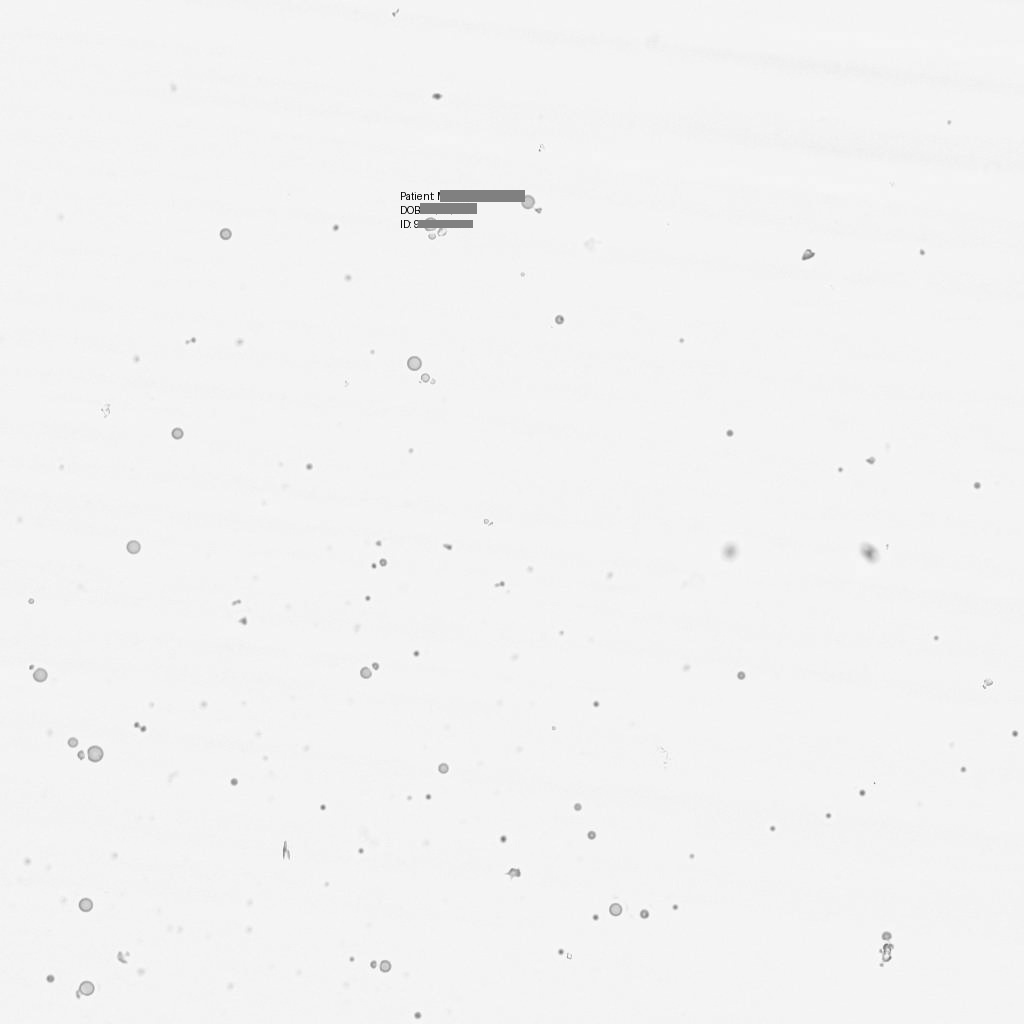

In [51]:
from sparkocr.utils import display_images
display_images(result_deid, "image_with_regions")

#### [optional] Alternative NLP pipeline
You can plug a play different NLP pipelines, consider taking a look at models on our models hub.

In [18]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparknlp.pretrained import PretrainedPipeline

In [19]:
deid_pipeline = PretrainedPipeline("ner_deid_context_augmented_pipeline", "en", "clinical/models")
stages = deid_pipeline.model.stages[0:7]

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(True) \
    .setUseCaching(True) \
    .setBatchSize(4)

stages.insert(0,ocr)

custom_ner_converter_internal = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_subentity"]) \
        .setOutputCol("ner_chunk_subentity") \
        .setThreshold(0.7) \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PERSON', 'DATE', 'IDNUM', 'DOCTOR', 'PATIENT', 'MEDICALRECORD', 'PHONE', 'CITY','ZIP'])

stages.append(custom_ner_converter_internal)

position_finder = PositionFinder() \
    .setInputCols("ner_chunk_subentity") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setOcrScaleFactor(0.9)

drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True) \
    .setRectColor(Color.gray)

stages.append(position_finder)
stages.append(drawRegions)
pipeline = Pipeline(stages=stages)

ner_deid_context_augmented_pipeline download started this may take some time.
Approx size to download 1.6 GB
[OK!]


In [20]:
result_deid = pipeline.fit(result).transform(result)
deid_info = result_deid.select("path", "coordinates").distinct()

In [21]:
deid_info.distinct().show(5, False)

+-------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|path                                       |coordinates                                                                                                                        |
+-------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------+
|file:/content/tiles_output/62893_L0_T4.png |[]                                                                                                                                 |
|file:/content/tiles_output/62893_L0_T5.png |[]                                                                                                                                 |
|file:/content/tiles_output/62893_L0_T6.png |[]                                                               

In [22]:
deid_info.repartition(10).write.format("parquet").mode("overwrite").save("./cached_regions.parquet")

In [23]:
deid_info = spark.read.parquet("./cached_regions.parquet").repartition(10)

In [ ]:
display_images(result_deid, "image_with_regions")

#### Masking of specific tiles in the SVS
This is our final step!. We will mask the specific tiles in the source SVS using the regions we obtained during previous steps.</br>
First, let's create a copy of our files.

In [25]:
!cp -r "$output_path" deid_svs_copy

In [14]:
from sparkocr.utils.svs.draw_bbox_on_tile import deidentify_svs_tile

deidentify_svs_tile("deid_svs_copy", deid_info.cache(), output_svs_path=None, create_new_svs_file = False)

Starting deidentification on SVS: deid_svs_copy/62893.svs
- svs_path: deid_svs_copy/62893.svs
Total pages in SVS: 2
